# Imports`

In [1]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d rohithramakrishnan/cxr2dvmd
! unzip cxr2dvmd.zip 

Saving kaggle.json to kaggle.json
  0% 0.00/10.1M [00:00<?, ?B/s]
100% 10.1M/10.1M [00:00<00:00, 93.2MB/s]
Archive:  cxr2dvmd.zip
  inflating: VMD/test/Negative for Pneumonia/010776c711bc.jpg  
  inflating: VMD/test/Negative for Pneumonia/0124f624dacb.jpg  
  inflating: VMD/test/Negative for Pneumonia/01aefe9ed777.jpg  
  inflating: VMD/test/Negative for Pneumonia/01e2538deeb0.jpg  
  inflating: VMD/test/Negative for Pneumonia/01fc054e43dd.jpg  
  inflating: VMD/test/Negative for Pneumonia/029fd29fcfff.jpg  
  inflating: VMD/test/Negative for Pneumonia/02cfb8970bca.jpg  
  inflating: VMD/test/Negative for Pneumonia/0326d6990386.jpg  
  inflating: VMD/test/Negative for Pneumonia/032f2ab06cad.jpg  
  inflating: VMD/test/Negative for Pneumonia/047d552a32a7.jpg  
  inflating: VMD/test/Negative for Pneumonia/049e68c02a31.jpg  
  inflating: VMD/test/Negative for Pneumonia/058d56025fa2.jpg  
  inflating: VMD/test/Negative for Pneumonia/0660475631a9.jpg  
  inflating: VMD/test/Negative for Pne

In [2]:
import os 
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import nasnet
from tensorflow.keras import models
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks 
from glob import glob
from keras import optimizers
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

In [3]:
size=512
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,vertical_flip=True)

Train_Data = train_datagen.flow_from_directory(
          '/content/VMD/train',
          target_size=(size, size),
          batch_size=32,
          class_mode='categorical',
          subset='training')

Val_Data = train_datagen.flow_from_directory(
        '/content/VMD/val',
        target_size=(size, size),
        batch_size=1,
        shuffle=False,
        class_mode='categorical',
        subset='training')

Test_Data = train_datagen.flow_from_directory(
        '/content/VMD/test',
        target_size=(size, size),
        batch_size=1,
        shuffle=False,
        class_mode='categorical',
        subset='training')

Found 439 images belonging to 2 classes.
Found 46 images belonging to 2 classes.
Found 59 images belonging to 2 classes.


# NASNet

In [4]:
vgg16= tf.keras.applications.VGG16(
    include_top=False,
    weights='imagenet',input_shape=(size,size,3)
)
# Freeze all the layers
for layer in vgg16.layers[:]:
    layer.trainable = True

58892288/58889256 [==============================] - 1s 0us/step


In [5]:
  num_classes = 2
# Create the model
  model = models.Sequential()

  # Add the vgg convolutional base model
  model.add(vgg16)
  # Add new layers

  model.add(layers.Flatten())
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dropout(0.3))
  model.add(layers.Dense(num_classes, activation='softmax'))
  model.build((size,size,3))
  # Show a summary of the model. Check the number of trainable parameters
  model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 16, 16, 512)       14714688  
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 512)               67109376  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 1026      
Total params: 81,825,090
Trainable params: 81,825,090
Non-trainable params: 0
_________________________________________________________________


In [6]:
optRMSProp=tf.keras.optimizers.RMSprop(learning_rate=0.00001, momentum=0.001, epsilon=1e-7, name="RMSprop",)
model.compile(optimizer=optRMSProp, loss="categorical_crossentropy",metrics=['accuracy'])

In [7]:
reduce_learning = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    verbose=1,
    mode='auto',
    min_delta=0.0001,
    cooldown=2,
    min_lr=0)

eary_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=10,
    verbose=1,
    mode='auto')

callback = [reduce_learning, eary_stopping]

In [8]:
VGG_16 =model.fit(Train_Data,validation_data = Val_Data,epochs=100,callbacks=callback)

Epoch 1/100
14/14 [==============================] - 125s 5s/step - loss: 0.7991 - accuracy: 0.5604 - val_loss: 0.6764 - val_accuracy: 0.6304
Epoch 2/100
14/14 [==============================] - 38s 3s/step - loss: 0.7224 - accuracy: 0.5626 - val_loss: 0.6105 - val_accuracy: 0.6304
Epoch 3/100
14/14 [==============================] - 38s 3s/step - loss: 0.6603 - accuracy: 0.6333 - val_loss: 0.5818 - val_accuracy: 0.6522
Epoch 4/100
14/14 [==============================] - 38s 3s/step - loss: 0.5775 - accuracy: 0.6743 - val_loss: 0.5395 - val_accuracy: 0.6957
Epoch 5/100
14/14 [==============================] - 38s 3s/step - loss: 0.5822 - accuracy: 0.7062 - val_loss: 0.4943 - val_accuracy: 0.6957
Epoch 6/100
14/14 [==============================] - 38s 3s/step - loss: 0.5505 - accuracy: 0.7107 - val_loss: 0.4928 - val_accuracy: 0.6739
Epoch 7/100
14/14 [==============================] - 39s 3s/step - loss: 0.4692 - accuracy: 0.8018 - val_loss: 0.5985 - val_accuracy: 0.6522
Epoch 8/100


In [9]:
predict1 = model.predict(Val_Data, steps=None)

In [10]:
in1=[]
for i in np.arange(predict1.shape[0]):
  A= np.max(predict1[i])
  index_1= np.where(predict1[i]==A)
  in1.append(index_1[0][0])
in1=np.array(in1)

VMDed Data
                        precision    recall  f1-score   support

Negative for Pneumonia       0.80      0.80      0.80        25
    Typical Appearance       0.76      0.76      0.76        21

              accuracy                           0.78        46
             macro avg       0.78      0.78      0.78        46
          weighted avg       0.78      0.78      0.78        46



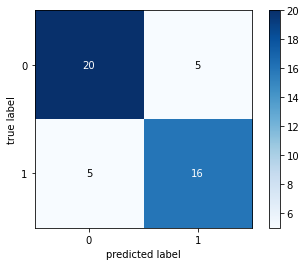

In [11]:
print("VMDed Data")
true_classes = Val_Data.classes
class_labels = list(Val_Data.class_indices.keys()) 
predicted_classes = (in1)
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)
cm1 = confusion_matrix(true_classes,predicted_classes)
#print(cm2)
#Visualizing confusion matrix
fig, ax = plot_confusion_matrix(conf_mat=cm1, colorbar=True)
plt.show()